In [81]:
!pip install ucimlrepo

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# 1. Data Acquisition and Preprocessing:

### Load the dataset into a Python environment using ucimlrepo.

In [82]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

data_obesity = fetch_ucirepo(id=544)
X = data_obesity.data.features
Y = data_obesity.data.targets
X.info()
print(Y.info())

In [83]:
data_obesity = fetch_ucirepo(id=544)

# Create a DataFrame with features and target
df = pd.DataFrame(data_obesity.data.features, columns=data_obesity.data.feature_names)
df['NObeyesdad'] = data_obesity.data.targets 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

### Examine the data structure, identifying numerical and categorical columns.

Numerical columns -> Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE

Categorical columns -> Gender, family_history_with_overweight, FAVC, CAEC, SMOKE, SCC, CALC, MTRANS, NObeyesdad

In [84]:
df['NObeyesdad'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

In [85]:
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Convert categorical variables into numerical variables using LabelEncoder.

In [87]:
categorical_columns = df.select_dtypes(include=['object']).columns
le = LabelEncoder()


for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   int32  
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   int32  
 5   FAVC                            2111 non-null   int32  
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   int32  
 9   SMOKE                           2111 non-null   int32  
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   int32  
 12  FAF                             21

In [88]:
# Split data into features and target
X = df.drop('NObeyesdad', axis=1)
Y = df['NObeyesdad']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,
                                               random_state=42)

In [89]:
X_train.shape

(1688, 16)

# 2. Feature Selection:

### Filter Method


In [90]:
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif


#with feature selection
select_features=SelectKBest(chi2,k=10)
X_train_selected=select_features.fit_transform(X_train,Y_train)
X_test_selected=select_features.transform(X_test)

selected_features = X.columns[select_features.get_support()]
print(selected_features)



Index(['Gender', 'Age', 'Weight', 'family_history_with_overweight', 'FCVC',
       'NCP', 'CAEC', 'SCC', 'FAF', 'MTRANS'],
      dtype='object')


In [91]:
print(X_train_selected.shape)
print(X_test_selected.shape)

(1688, 10)
(423, 10)


### Wrapper Method

In [92]:
!pip install mlxtend

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.metrics import accuracy_score

log_reg=LogisticRegression(max_iter=1000,solver='liblinear',random_state=42)

### SequentialFeatureSelector

In [94]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


sfs=SFS(estimator=log_reg,
                             k_features=10,
                             forward=True,
                             floating=False,
                             scoring='accuracy',
                             cv=5)

sfs=sfs.fit(X_train,Y_train)
selected_feature_names = sfs.k_feature_names_
print("Selected Features:", selected_feature_names)

Selected Features: ('Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'CH2O', 'FAF')


### Embedded Method: Use feature importance derived from Random Forest.

In [95]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, Y_train)

feature_importances = rf_classifier.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


num_selected_features = 5  # Arbitrary k=5
selected_embedded_features = feature_importance_df['feature'][:num_selected_features].to_list()
X_train_embedded = X_train[selected_embedded_features]
X_test_embedded = X_test[selected_embedded_features]

print(selected_embedded_features)

['Weight', 'Height', 'Age', 'FCVC', 'Gender']


# 3. Model Training and Evaluation:

### Train and evaluate Logistic Regression and Support Vector Classifier (SVC) models:

### Logistic regression :- Without Feature Selection

In [96]:
log_reg.fit(X_train, Y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate Logistic Regression model
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,accuracy_score,confusion_matrix

log_reg = LogisticRegression(penalty='l2',C=1.0,fit_intercept=True,
                             random_state=None,solver='liblinear',
                             max_iter=1000,multi_class='auto',
                             verbose=0,warm_start=False)
accuracy=accuracy_score(Y_test,y_pred_log_reg)
print("Accuracy is:",accuracy*100)

print(classification_report(Y_test,y_pred_log_reg))

Accuracy is: 71.39479905437352
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        56
           1       0.79      0.35      0.49        62
           2       0.65      0.58      0.61        78
           3       0.75      0.98      0.85        58
           4       0.93      1.00      0.96        63
           5       0.61      0.62      0.62        56
           6       0.44      0.54      0.49        50

    accuracy                           0.71       423
   macro avg       0.71      0.72      0.70       423
weighted avg       0.72      0.71      0.70       423



### Support Vector Machine:- Without Feature Selection:

In [97]:
from sklearn.svm import SVC
# Split the data into training and testing sets


svc = SVC(C=1.0,
          kernel='linear',
          gamma='scale',
          shrinking=True,
          probability=False,
          cache_size=200,
          class_weight=None,
          verbose=False,
          max_iter=1000,
          decision_function_shape='ovr',
          break_ties=True,
          random_state=None)



svc.fit(X_train, Y_train)
s_pred = svc.predict(X_test)

print(classification_report(Y_test,s_pred))

print("Accuracy: ",accuracy_score(Y_test,s_pred)*100)




              precision    recall  f1-score   support

           0       0.87      0.96      0.92        56
           1       0.91      0.63      0.74        62
           2       0.93      0.71      0.80        78
           3       0.92      1.00      0.96        58
           4       1.00      1.00      1.00        63
           5       0.63      0.64      0.64        56
           6       0.49      0.74      0.59        50

    accuracy                           0.81       423
   macro avg       0.82      0.81      0.81       423
weighted avg       0.84      0.81      0.81       423

Accuracy:  80.85106382978722


C:\Users\Aishwarya\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


### Logistic Regression :- With Feature Selection:

In [98]:
#Filter method
log_reg_filter = LogisticRegression(penalty='l2',C=1.0,fit_intercept=True,
                             random_state=None,solver='lbfgs',
                             max_iter=1000,multi_class='auto',
                             verbose=0,warm_start=False)

log_reg_filter.fit(X_train_selected, Y_train)
y_pred_log_reg_filter = log_reg_filter.predict(X_test_selected)
print("\n-------Filter Method (Logistic Regression)-------")

print("Classification Report:\n", classification_report(Y_test, y_pred_log_reg_filter))

print("Accuracy:", accuracy_score(Y_test, y_pred_log_reg_filter)*100)


#Wrapper method
log_reg_wrapper = LogisticRegression(penalty='l2',C=1.0,fit_intercept=True,
                             random_state=None,solver='lbfgs',
                             max_iter=1000,multi_class='auto',
                             verbose=0,warm_start=False)
X_train_wrapper = X_train[list(selected_feature_names)]
X_test_wrapper = X_test[list(selected_feature_names)]
log_reg_wrapper.fit(X_train_wrapper, Y_train)
y_pred_log_reg_wrapper = log_reg_wrapper.predict(X_test_wrapper)
print("\n-------Wrapper Method (Logistic Regression)-------")

print("Classification Report:\n", classification_report(Y_test, y_pred_log_reg_wrapper))

print("Accuracy:", accuracy_score(Y_test, y_pred_log_reg_wrapper)*100)

#Embedded Method
log_reg_embedded = LogisticRegression(penalty='l2',C=1.0,fit_intercept=True,
                             random_state=None,solver='lbfgs',
                             max_iter=1000,multi_class='auto',
                             verbose=0,warm_start=False)
X_train_embedded_selected = X_train[selected_embedded_features]
X_test_embedded_selected = X_test[selected_embedded_features]
log_reg_embedded.fit(X_train_embedded_selected, Y_train)
y_pred_log_reg_embedded = log_reg_embedded.predict(X_test_embedded_selected)

print("\n-------Embedded Method (Logistic Regression)-------")

print("Classification Report:\n", classification_report(Y_test, y_pred_log_reg_embedded))

print("Accuracy:", accuracy_score(Y_test, y_pred_log_reg_embedded)*100)



C:\Users\Aishwarya\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



-------Filter Method (Logistic Regression)-------
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86        56
           1       0.77      0.48      0.59        62
           2       0.70      0.60      0.65        78
           3       0.76      0.93      0.84        58
           4       0.93      1.00      0.96        63
           5       0.52      0.52      0.52        56
           6       0.40      0.46      0.43        50

    accuracy                           0.70       423
   macro avg       0.70      0.70      0.69       423
weighted avg       0.71      0.70      0.70       423

Accuracy: 70.44917257683215


C:\Users\Aishwarya\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



-------Wrapper Method (Logistic Regression)-------
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.85        56
           1       0.89      0.40      0.56        62
           2       0.86      0.79      0.83        78
           3       0.84      1.00      0.91        58
           4       0.93      1.00      0.96        63
           5       0.62      0.73      0.67        56
           6       0.59      0.58      0.59        50

    accuracy                           0.78       423
   macro avg       0.78      0.78      0.77       423
weighted avg       0.80      0.78      0.77       423

Accuracy: 78.4869976359338

-------Embedded Method (Logistic Regression)-------
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88        56
           1       0.72      0.58      0.64        62
           2       0.84      0.74      0.79        78
      

C:\Users\Aishwarya\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Support Vector Machine:- With Feature Selection

In [99]:
# Filter method:
svm_filter = SVC(C=1.0,
       kernel='rbf',
       degree=3,
       gamma='scale',
       coef0=0.0,
       shrinking=True,
       probability=False,
       cache_size=200,
       class_weight=None,#[0.2,0.4] or balanced
        verbose=False,
        max_iter=1000,
        decision_function_shape='ovr',
        break_ties=False,
        random_state=None)

svm_filter.fit(X_train_selected, Y_train)
y_pred_svm_filter = svm_filter.predict(X_test_selected)
print("\n-------Filter Method (SVM)------")

print("Classification Report:\n", classification_report(Y_test, y_pred_svm_filter))

print("Accuracy:", accuracy_score(Y_test, y_pred_svm_filter)*100)

#Wrapper Method:
svm_wrapper = SVC(#C=1.0,
       kernel='rbf',
       degree=3,
       gamma='scale',
       coef0=0.0,
       shrinking=True,
       probability=False,
       cache_size=200,
       class_weight=None,#[0.2,0.4] or balanced
        verbose=False,
        max_iter=1000,
        decision_function_shape='ovr',
        break_ties=False,
        random_state=None)

svm_wrapper.fit(X_train_wrapper, Y_train)
y_pred_svm_wrapper = svm_wrapper.predict(X_test_wrapper)
print("\n-------Wrapper Method (SVM)-------")

print("Classification Report:\n", classification_report(Y_test, y_pred_svm_wrapper))

print("Accuracy:", accuracy_score(Y_test, y_pred_svm_wrapper)*100)

#Embedded Method
svm_embedded = SVC(C=1.0,
       kernel='rbf',
       degree=3,
       gamma='scale',
       coef0=0.0,
       shrinking=True,
       probability=False,
       cache_size=200,
       class_weight=None,#[0.2,0.4] or balanced
        verbose=False,
        max_iter=1000,
        decision_function_shape='ovr',
        break_ties=False,
        random_state=None)

svm_embedded.fit(X_train_embedded_selected, Y_train)
y_pred_svm_embedded = svm_embedded.predict(X_test_embedded_selected)

print("\n-------Embedded Method (SVM)-------")

print("Classification Report:\n", classification_report(Y_test, y_pred_svm_embedded))

print("Accuracy:", accuracy_score(Y_test, y_pred_svm_embedded)*100)


-------Filter Method (SVM)------
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.78        56
           1       0.48      0.34      0.40        62
           2       0.65      0.33      0.44        78
           3       0.77      0.41      0.54        58
           4       0.56      1.00      0.72        63
           5       0.47      0.48      0.47        56
           6       0.43      0.58      0.49        50

    accuracy                           0.57       423
   macro avg       0.58      0.57      0.55       423
weighted avg       0.59      0.57      0.54       423

Accuracy: 56.50118203309693

-------Wrapper Method (SVM)-------
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.78        56
           1       0.48      0.34      0.40        62
           2       0.63      0.33      0.44        78
           3       0.77      0.40      0

# 4. Decision Tree and Random Forest Analysis:


### Train Decision Tree and Random Forest models on the dataset

In [100]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Initialize classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)

# Train the models
dt_classifier.fit(X_train, Y_train)
rf_classifier.fit(X_train, Y_train)

# Predict using the trained models
dt_pred = dt_classifier.predict(X_test)
rf_pred = rf_classifier.predict(X_test)



### Interpret the Decision Tree structure (e.g., visualize the tree using plot_tree() from sklearn).

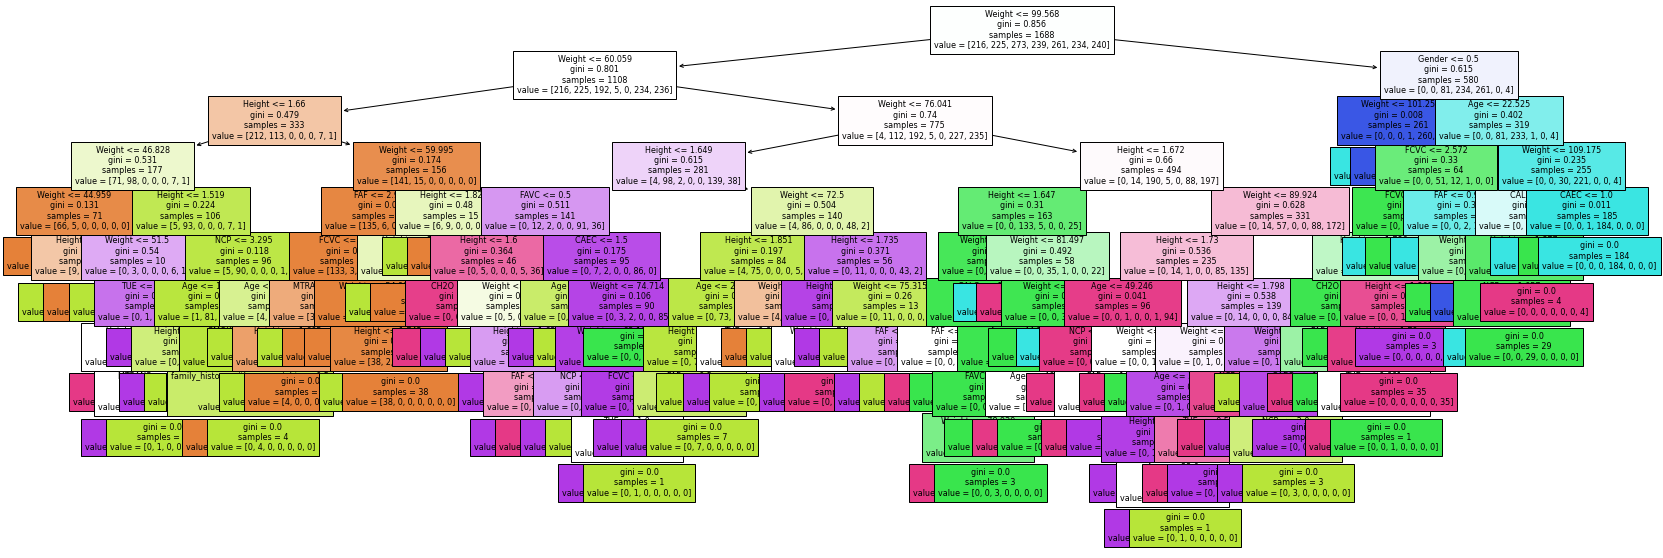

In [101]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(28,10))
plot_tree(dt_classifier, feature_names=X_train.columns, filled=True, fontsize=8)
plt.show()

### Use feature importance values from Random Forest to identify the most important features.

In [102]:
rf=RandomForestClassifier(
    n_estimators=100, #number of trees smaller dataset with fewer features 50 Larger dataset or high dimension 200 or 500
    criterion='gini', #default is gini or use entropy info gain dataset class imbalance or categorical features
    max_depth=None, # small dataset 5 or 10 prevent overfitting larger dataset None
    min_samples_split=2, # nosiy data 5 or 10
    min_samples_leaf=1, #for most of the dataset
    max_features='sqrt',#perform best split of features or log2 or fixed
    bootstrap=True,#small dataset make it to be false
    random_state=None
    
    )

rf.fit(X_train,Y_train)
rf_pred=rf.predict(X_test)
important_feature=rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': important_feature
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                           Feature  Importance
3                           Weight    0.338986
2                           Height    0.104213
1                              Age    0.100020
6                             FCVC    0.085710
0                           Gender    0.051648
7                              NCP    0.050027
13                             TUE    0.047811
12                             FAF    0.043909
10                            CH2O    0.043386
8                             CAEC    0.034419
14                            CALC    0.031803
4   family_history_with_overweight    0.028769
15                          MTRANS    0.017713
5                             FAVC    0.015218
11                             SCC    0.004593
9                            SMOKE    0.001778


### Evaluate and compare model performance with accuracy and other metrics.

In [105]:
print("------Decision Tree Classifier:-------")
print("Accuracy:", accuracy_score(Y_test, dt_pred))
print(classification_report(Y_test, dt_pred))

print("-------Random Forest Classifier:------")
print("Accuracy:", accuracy_score(Y_test, rf_pred))
print(classification_report(Y_test, rf_pred))

------Decision Tree Classifier:-------
Accuracy: 0.933806146572104
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        56
           1       0.84      0.87      0.86        62
           2       0.96      0.92      0.94        78
           3       0.95      0.95      0.95        58
           4       1.00      1.00      1.00        63
           5       0.91      0.88      0.89        56
           6       0.96      0.96      0.96        50

    accuracy                           0.93       423
   macro avg       0.93      0.93      0.93       423
weighted avg       0.93      0.93      0.93       423

-------Random Forest Classifier:------
Accuracy: 0.9574468085106383
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.88      0.94      0.91        62
           2       0.99      0.97      0.98        78
           3       0.97      0.98      0.97        

# 5. Comparison and Interpretation:

### Create a table summarizing the results of all models with and without feature selection.

In [104]:
import pandas as pd

# [accuracy, precision, recall, f1_score]
lr_no_fs_results = [0.71, 0.72, 0.71, 0.70]
lr_filter_results = [0.70, 0.71, 0.70, 0.70]
lr_wrapper_results = [0.78, 0.80, 0.78, 0.77]
lr_embedded_results = [0.76, 0.76, 0.77, 0.76]

svc_no_fs_results = [0.80, 0.84, 0.81, 0.81]
svc_filter_results = [0.56, 0.58, 0.56, 0.54]
svc_wrapper_results = [0.56, 0.58, 0.56, 0.54]
svc_embedded_results = [0.56, 0.58, 0.56, 0.54]

dt_results = [0.93, 0.93, 0.93, 0.93]
rf_results = [0.96, 0.96, 0.96, 0.96]

# Creating the results table
results_table = pd.DataFrame(
    {
        "Model": [
            "Logistic Regression (No FS)",
            "Logistic Regression (Filter)",
            "Logistic Regression (Wrapper)",
            "Logistic Regression (Embedded)",
            "SVC (No FS)",
            "SVC (Filter)",
            "SVC (Wrapper)",
            "SVC (Embedded)",
            "Decision Tree",
            "Random Forest"
        ],
        "Accuracy": [
            lr_no_fs_results[0],
            lr_filter_results[0],
            lr_wrapper_results[0],
            lr_embedded_results[0],
            svc_no_fs_results[0],
            svc_filter_results[0],
            svc_wrapper_results[0],
            svc_embedded_results[0],
            dt_results[0],
            rf_results[0],
        ],
        "Precision": [
            lr_no_fs_results[1],
            lr_filter_results[1],
            lr_wrapper_results[1],
            lr_embedded_results[1],
            svc_no_fs_results[1],
            svc_filter_results[1],
            svc_wrapper_results[1],
            svc_embedded_results[1],
            dt_results[1],
            rf_results[1],
        ],
        "Recall": [
            lr_no_fs_results[2],
            lr_filter_results[2],
            lr_wrapper_results[2],
            lr_embedded_results[2],
            svc_no_fs_results[2],
            svc_filter_results[2],
            svc_wrapper_results[2],
            svc_embedded_results[2],
            dt_results[2],
            rf_results[2],
        ],
        "F1-Score": [
            lr_no_fs_results[3],
            lr_filter_results[3],
            lr_wrapper_results[3],
            lr_embedded_results[3],
            svc_no_fs_results[3],
            svc_filter_results[3],
            svc_wrapper_results[3],
            svc_embedded_results[3],
            dt_results[3],
            rf_results[3],
        ]
    }
)

# Display the results table
print(results_table)


                            Model  Accuracy  Precision  Recall  F1-Score
0     Logistic Regression (No FS)      0.71       0.72    0.71      0.70
1    Logistic Regression (Filter)      0.70       0.71    0.70      0.70
2   Logistic Regression (Wrapper)      0.78       0.80    0.78      0.77
3  Logistic Regression (Embedded)      0.76       0.76    0.77      0.76
4                     SVC (No FS)      0.80       0.84    0.81      0.81
5                    SVC (Filter)      0.56       0.58    0.56      0.54
6                   SVC (Wrapper)      0.56       0.58    0.56      0.54
7                  SVC (Embedded)      0.56       0.58    0.56      0.54
8                   Decision Tree      0.93       0.93    0.93      0.93
9                   Random Forest      0.96       0.96    0.96      0.96


### Discuss the impact of feature selection on model performance.

Impact of Feature Selection on Model Performance:

Improved Accuracy:-
By selecting the most relevant features, models can focus on important patterns, improving predictive accuracy.

Reduced Overfitting:-
Eliminating irrelevant or redundant features reduces noise, helping the model generalize better on unseen data.

Faster Training:
Fewer features decrease computational complexity, resulting in quicker training and evaluation.

Enhanced Interpretability:
With fewer features, it is easier to understand the model's decisions and identify key factors influencing predictions.

Better Model Stability:
Focused feature subsets ensure that small changes in data do not overly affect model performance.

->Feature selection improves accuracy, reduces overfitting, makes models faster, and enhances interpretability.
->It ensures models focus only on the most relevant information for better predictions.

### Identify the most effective feature selection method and the best-performing model.


Best Feature Selection Method:- Wrapper Method (for Logistic Regression).
Best-Performing Model:- Random Forest, demonstrating robust performance across all metrics.